In [124]:
import os
from graphgym.custom_graphgym.loader.protein import ProteinDataset

In [125]:
os.chdir('/Users/cgu3/Documents/Grape-Pi')

In [126]:
dataset = ProteinDataset("data/gastric-multi-graph", numeric_columns=['protein_probability'], label_column='protein_probability_soft_label', rebuild=True)
# dataset = ProteinDataset("data/yeast-ORBI", numeric_columns=['protein_probability'], label_column=None, rebuild=True)
# dataset = ProteinDataset("data/human-ORBI", numeric_columns=['protein_probability'], label_column='label', rebuild=True)
# dataset = ProteinDataset("data/yeast-ORBI", numeric_columns=['protein_probability', 'mRNA_TPM'], label_column=None, rebuild=True)

Rebuilding...
Done!


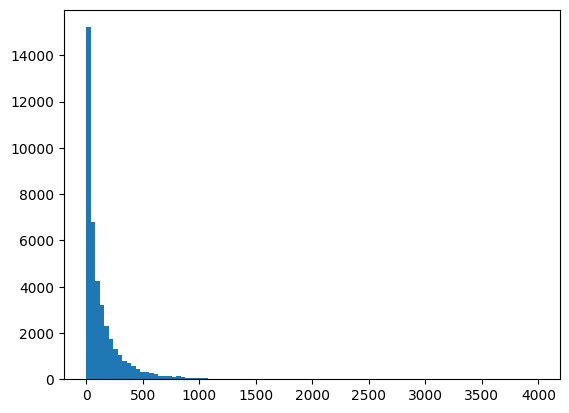

In [127]:
from matplotlib import pyplot as plt
from torch_geometric.utils import  degree
plt.hist(degree(dataset.edge_index[0]), bins=100);

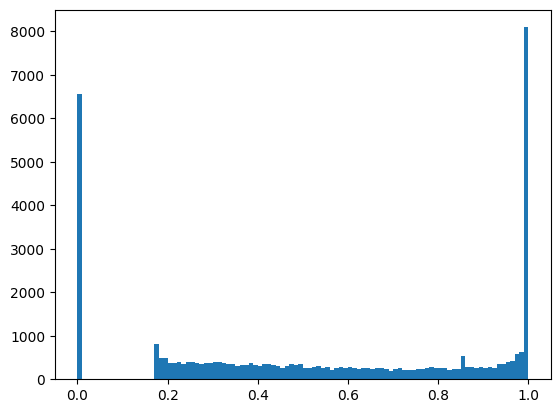

In [128]:
plt.hist(dataset.x[:, 0], bins=100);

In [129]:
dataset.num_features

1

In [120]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [122]:
import os.path as osp
import time

import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, 10, heads=4)
        self.lin1 = torch.nn.Linear(dataset.num_features, 4 * 10)
        # self.conv2 = GATConv(4 * 256, 256, heads=4)
        # self.lin2 = torch.nn.Linear(4 * 256, 4 * 256)
        self.conv3 = GATConv(4 * 10, 1, heads=6,
                             concat=False)
        self.lin3 = torch.nn.Linear(4 * 10, 1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        # x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index).squeeze(-1), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss


@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device))
        preds.append(torch.nn.functional.sigmoid(out))

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    y, pred = torch.tensor(y), torch.tensor(pred)
    return loss_op(y, pred.squeeze(-1))


times = []
for epoch in range(1, 101):
    start = time.time()
    loss = train()
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_f1:.4f}, '
          f'Test: {test_f1:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 001, Loss: 1.2447, Val: 0.5539, Test: 0.5539
Epoch: 002, Loss: 1.2009, Val: 0.5325, Test: 0.5325
Epoch: 003, Loss: 1.1905, Val: 0.5590, Test: 0.5590
Epoch: 004, Loss: 1.1446, Val: 0.6032, Test: 0.6032
Epoch: 005, Loss: 1.1333, Val: 0.6311, Test: 0.6311
Epoch: 006, Loss: 1.1362, Val: 0.6223, Test: 0.6223
Epoch: 007, Loss: 1.1204, Val: 0.5948, Test: 0.5948
Epoch: 008, Loss: 1.1077, Val: 0.5718, Test: 0.5718
Epoch: 009, Loss: 1.1071, Val: 0.5634, Test: 0.5634
Epoch: 010, Loss: 1.1042, Val: 0.5691, Test: 0.5691
Epoch: 011, Loss: 1.0942, Val: 0.5838, Test: 0.5838
Epoch: 012, Loss: 1.0856, Val: 0.5985, Test: 0.5985
Epoch: 013, Loss: 1.0816, Val: 0.6034, Test: 0.6034
Epoch: 014, Loss: 1.0762, Val: 0.5959, Test: 0.5959
Epoch: 015, Loss: 1.0680, Val: 0.5829, Test: 0.5829
Epoch: 016, Loss: 1.0618, Val: 0.5735, Test: 0.5735
Epoch: 017, Loss: 1.0578, Val: 0.5723, Test: 0.5723
Epoch: 018, Loss: 1.0526, Val: 0.5785, Test: 0.5785
Epoch: 019, Loss: 1.0471, Val: 0.5866, Test: 0.5866
Epoch: 020, 

KeyboardInterrupt: 